In [1]:
## Installing and importing necessary modules for data


!pip install folktables
!pip install aif360
!pip install 'aif360[LawSchoolGPA]'
!pip install 'aif360[Reductions]'


## Data preprocessing steps

In [32]:
import folktables
from folktables import ACSDataSource
import numpy as np

# (Age) must be greater than 16 and less than 90, and (Person weight) must be
# greater than or equal to 1
def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

ACSEmployment = folktables.BasicProblem(
    features=[
        'AGEP', # age; for range of values of features please check Appendix B.4 of
                # Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
        'SCHL', # educational attainment
        'MAR', # marital status
        'RELP', # relationship
        'DIS', # disability recode
        'ESP', # employment status of parents
        'CIT', # citizenship status
        'MIG', # mobility status (lived here 1 year ago)
        'MIL', # military service
        'ANC', # ancestry recode
        'NATIVITY', # nativity
        'DEAR', # hearing difficulty
        'DEYE', # vision difficulty
        'DREM', # cognitive difficulty
        'SEX', # sex
        'RAC1P', # recoded detailed race code
        'GCL', # grandparents living with grandchildren
    ],
    target='ESR', # employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True) # data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)


In [33]:
from aif360.datasets import StandardDataset
import pandas as pd
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes,
                               protected_attribute_names = protected_attribute_names,
                               privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 2}]
unprivileged_groups = [{'DIS': 1}]


/usr/local/lib/python3.10/dist-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


##Task 1a

In [62]:
# importing necessary modules


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.metrics import ClassificationMetric
import numpy as np
import matplotlib.pyplot as plt
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

In [63]:
# first, we split dataset into train (0.7) and test (0.3)
dataset_size = data_for_aif.features.shape[0]
train, test = data_for_aif.split([int(dataset_size*0.7)], shuffle=True)
print(train.features.shape) # train size
print(test.features.shape) # test size

# obtain test dataset
X_test = test.features
y_test = test.labels.ravel()

# then, split train into train-train (0.8) and train-val (0.2). 5 sets in total
train_train_list = []
train_val_list = []
for i in range(5):
    train_train, train_val = train.split([int(train.features.shape[0]*0.8)], shuffle=True)
    train_train_list.append(train_train)
    train_val_list.append(train_val)


(117114, 168)
(50192, 168)


##Task 1b: selecting standard model with highest accuracy

In [ ]:
# Array of regularisation strengths for logistic regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# Initialising variables to track the best accuracy and fairness
best_acc = 0
best_fairness = float('inf')
best_acc_C_val = None  # C value yielding best accuracy
best_fairness_C_val = None  # C value yielding best fairness
best_model_for_acc = None  # Model with best accuracy
best_model_for_fairness = None  # Model with best fairness
best_fairness_acc = None  # Accuracy when fairness is optimised

# Iterating over the range of C values
for C_val in C_vals:
    accuracies = []  # List to store accuracies
    fairness_metrics = []  # List to store fairness metrics

    # Training and validation cycle
    for train_train, train_val in zip(train_train_list, train_val_list):
        # Fit model on training data
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train.features, train_train.labels.ravel())

        # Assess accuracy on validation set
        val_preds = lr_model.predict(train_val.features)
        accuracy = accuracy_score(train_val.labels.ravel(), val_preds)
        accuracies.append(accuracy)

        # Assess fairness on validation set
        val_pred = train_val.copy()
        val_pred.labels = val_preds
        metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        fairness = metric.equal_opportunity_difference()
        fairness_metrics.append(fairness)

    # Calculating average accuracy and fairness for the current C value
    avg_acc = np.mean(accuracies)
    avg_fairness = np.mean(fairness_metrics)

    # Update tracking variables if current model is the best so far
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_acc_C_val = C_val
        best_model_for_acc = lr_model
    if abs(avg_fairness) < abs(best_fairness):
        best_fairness = avg_fairness
        best_fairness_C_val = C_val
        best_model_for_fairness = lr_model
        best_fairness_acc = avg_acc  # Record accuracy at best fairness

# Testing phase for the best model based on accuracy
test_preds_for_acc = best_model_for_acc.predict(X_test)
final_acc = accuracy_score(y_test, test_preds_for_acc)

# Computing and reporting fairness of the accuracy-optimised model
test_pred_for_acc = test.copy()
test_pred_for_acc.labels = test_preds_for_acc
metric_test_for_acc = ClassificationMetric(test, test_pred_for_acc, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_eq_opp_diff_for_acc = metric_test_for_acc.equal_opportunity_difference()

# Testing phase for the best model based on fairness
test_preds_for_fairness = best_model_for_fairness.predict(X_test)
final_acc_for_fairness = accuracy_score(y_test, test_preds_for_fairness)

# Computing and reporting fairness of the fairness-optimised model
test_pred_for_fairness = test.copy()
test_pred_for_fairness.labels = test_preds_for_fairness
metric_test_for_fairness = ClassificationMetric(test, test_pred_for_fairness, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_eq_opp_diff_for_fairness = metric_test_for_fairness.equal_opportunity_difference()

# Final reporting on accuracy and fairness for the best models
print(f'Best C value for Accuracy: {best_acc_C_val}')
print(f'Best C value for Fairness: {best_fairness_C_val}')
print(f'Accuracy when Fairness is best: {best_fairness_acc}')
print(f'Final Test Accuracy of Best Accuracy Model: {final_acc}')
print(f'Final Test Fairness (Equal Opportunity Difference) of Best Accuracy Model: {final_eq_opp_diff_for_acc}')
print(f'Final Test Accuracy of Best Fairness Model: {final_acc_for_fairness}')
print(f'Final Test Fairness (Equal Opportunity Difference) of Best Fairness Model: {final_eq_opp_diff_for_fairness}')


C=0.0001, Average Validation Accuracy: 0.7381377278743116, Average Validation Fairness: -0.32927572930643995
C=0.001, Average Validation Accuracy: 0.7500320198095888, Average Validation Fairness: -0.507276713743039
C=0.01, Average Validation Accuracy: 0.7534389275498441, Average Validation Fairness: -0.5992044241487205
C=0.1, Average Validation Accuracy: 0.7538402424966913, Average Validation Fairness: -0.6131118779622184
C=1, Average Validation Accuracy: 0.7538060880331299, Average Validation Fairness: -0.6166486741935845
C=10, Average Validation Accuracy: 0.7538146266490202, Average Validation Fairness: -0.6172141079236466
C=100, Average Validation Accuracy: 0.7538317038808009, Average Validation Fairness: -0.617248647753889
C=1000, Average Validation Accuracy: 0.7538231652649104, Average Validation Fairness: -0.6171969544896833
Best C value for Accuracy: 0.1
Best C value for Fairness: 0.0001
Accuracy when Fairness is best: 0.7381377278743116
Final Test Accuracy of Best Accuracy Mode

##Task 1c: selecting standard model with best fairness metric

In [ ]:
# Array of regularisation strengths for logistic regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
best_fairness = float('inf')
best_fairness_C_val = None
best_fairness_model = None
best_fairness_accuracy = None

# Iterating over the range of C values
for C_val in C_vals:
    fairness_metrics = []
    accuracies = []

    # Training and validation cycle
    for train_train, train_val in zip(train_train_list, train_val_list):
        # Train model
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train.features, train_train.labels.ravel())

        # Assess accuracy on validation set
        val_preds = lr_model.predict(train_val.features)
        val_accuracy = accuracy_score(train_val.labels.ravel(), val_preds)
        accuracies.append(val_accuracy)

        # Assess fairness on validation set
        val_pred = train_val.copy()
        val_pred.labels = val_preds
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fairness_metrics.append(eq_opp_diff)

    # Calculating average accuracy and fairness for the current C value
    avg_fairness = np.mean(fairness_metrics)
    avg_accuracy = np.mean(accuracies)
    print(f'C={C_val}, Average Validation Fairness (Equal Opportunity Difference): {avg_fairness}, Average Validation Accuracy: {avg_accuracy}')

    # Update best fairness model if current model is fairer
    if abs(avg_fairness) < abs(best_fairness):
        best_fairness = avg_fairness
        best_fairness_C_val = C_val
        best_fairness_model = lr_model
        best_fairness_accuracy = avg_accuracy

# Testing phase for the best model based on accuracy
test_preds = best_fairness_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Computing fairness for the best fairness model
test_pred = test.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# Reporting final accuracy and fairness for the best fairness model
print(f'Best C value for Fairness: {best_fairness_C_val}')
print(f'Accuracy for the Best Fairness Model: {best_fairness_accuracy}')
print(f'Final Test Accuracy of the Best Fairness Model: {final_acc}')
print(f'Final Test Fairness (Equal Opportunity Difference) of the Best Fairness Model: {final_fairness_metric}')


C=0.0001, Average Validation Fairness (Equal Opportunity Difference): -0.32927572930643995, Average Validation Accuracy: 0.7381377278743116
C=0.001, Average Validation Fairness (Equal Opportunity Difference): -0.507276713743039, Average Validation Accuracy: 0.7500320198095888
C=0.01, Average Validation Fairness (Equal Opportunity Difference): -0.5992044241487205, Average Validation Accuracy: 0.7534389275498441
C=0.1, Average Validation Fairness (Equal Opportunity Difference): -0.6131118779622184, Average Validation Accuracy: 0.7538402424966913
C=1, Average Validation Fairness (Equal Opportunity Difference): -0.6166486741935845, Average Validation Accuracy: 0.7538060880331299
C=10, Average Validation Fairness (Equal Opportunity Difference): -0.6172141079236466, Average Validation Accuracy: 0.7538146266490202
C=100, Average Validation Fairness (Equal Opportunity Difference): -0.617248647753889, Average Validation Accuracy: 0.7538317038808009
C=1000, Average Validation Fairness (Equal Opp

##Plotting results of tasks 1b and 1c together

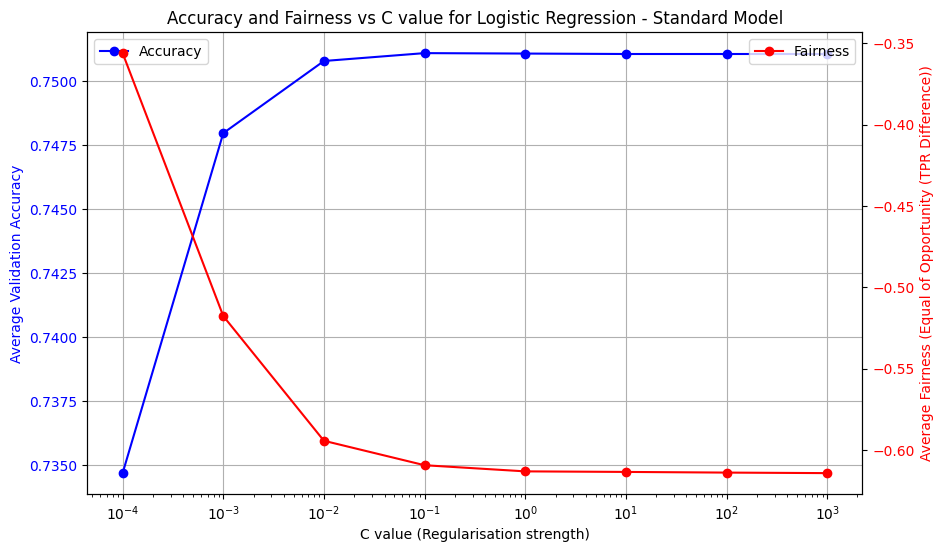

In [ ]:
# Range of C values for Logistic Regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
avg_accuracies = [0.7346881270546046, 0.7479656747641207, 0.7507834180079409,
                  0.751090808179994, 0.7510737309482133, 0.7510566537164326, 0.7510566537164326, 0.7510566537164326]
avg_fairnesses = [-0.3561291042764412, -0.5176610047593677, -0.5942625687301202,
                  -0.6092828780146914, -0.6130552287600122, -0.6133962357153984, -0.6138072088798466, -0.6141323221450352]

# Create figure and first axis
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plotting accuracy
ax1.plot(C_vals, avg_accuracies, 'b-o', label='Accuracy')
ax1.set_xlabel('C value (Regularisation strength)')
ax1.set_ylabel('Average Validation Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xscale('log')

# Plotting fairness
ax2.plot(C_vals, avg_fairnesses, 'r-o', label='Fairness')
ax2.set_ylabel('Average Fairness (Equal of Opportunity (TPR Difference))', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xscale('log')

# Title and grid
plt.title('Accuracy and Fairness vs C value for Logistic Regression - Standard Model')
ax1.grid(True)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


##Task 2a: Reweighing technique of Kamiran and Calders (2012)
##Selecting reweighed model with highest accuracy

In [ ]:
# Varying the regularisation strength to determine the Best Fairness and Best Accuracy models
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
acc_compare_reweigh = {}  # Stores accuracies for different models
fair_compare_reweigh = {}  # Stores fairness for different models
best_acc = 0
best_fairness = float('inf')
best_acc_C_val = None
best_fairness_C_val = None
best_acc_model = None
best_fairness_model = None

# applying reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Iterating over the range of C values
for C_val in C_vals:
    acc_kfold = []
    fair_kfold = []

    # Training and validation for each split
    for train_train, train_val in zip(train_train_list, train_val_list):
        train_train = RW.fit_transform(train_train)
        X_train = train_train.features
        y_train = train_train.labels.ravel()
        X_val = train_val.features
        y_val = train_val.labels.ravel()

        # Logistic Regression
        learner = LogisticRegression(C=C_val, solver='liblinear', penalty='l1', random_state=1)
        learner.fit(X_train, y_train, sample_weight=train_train.instance_weights)
        predictions = learner.predict(X_val)

        # Calculate accuracy
        accuracy = sum(predictions == y_val) / len(y_val)
        acc_kfold.append(accuracy)

        # Calculate fairness using Equal Opportunity Difference
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    # Average over the 5 folds
    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)
    acc_compare_reweigh[C_val] = avg_acc
    fair_compare_reweigh[C_val] = avg_fairness

    # Check if this model is the best so far based on accuracy
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_acc_C_val = C_val
        best_acc_model = learner

    # Check if this model is the best so far based on fairness
    if abs(avg_fairness) < abs(best_fairness):
        best_fairness = avg_fairness
        best_fairness_C_val = C_val
        best_fairness_model = learner

# Evaluating the best accuracy model on the test set
test_preds_acc = best_acc_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds_acc)

# Computing fairness on the test set for the best accuracy model
test_pred_acc = test.copy()
test_pred_acc.labels = test_preds_acc
metric_test_acc = ClassificationMetric(test, test_pred_acc, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric_acc = metric_test_acc.equal_opportunity_difference()

# Evaluating the best fairness model on the test set
test_preds_fair = best_fairness_model.predict(X_test)
final_acc_fair = accuracy_score(y_test, test_preds_fair)

# Computing fairness on the test set for the best fairness model
test_pred_fair = test.copy()
test_pred_fair.labels = test_preds_fair
metric_test_fair = ClassificationMetric(test, test_pred_fair, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric_fair = metric_test_fair.equal_opportunity_difference()

# Reporting final accuracy and fairness
print(f'Best C value for Accuracy: {best_acc_C_val}')
print(f'Best C value for Fairness: {best_fairness_C_val}')




Best C value for Accuracy: 0.001
Best C value for Fairness: 0.01


In [64]:
# Varying the regularisation strength to determine the Best Fairness and Best Accuracy models
C_vals = [1e-4, 1e-3,  1e-2, 1e-1, 1, 10, 100, 1000]
acc_compare_reweigh = {}
fair_compare_reweigh = {}
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

best_acc = 0
best_model = None

# Iterating over the range of C values
for C_val in C_vals:
  acc_kfold = []
  fair_kfold = []

  for train_train, train_val in zip(train_train_list, train_val_list):
    train_train = RW.fit_transform(train_train)
    X_train = train_train.features
    y_train = train_train.labels.ravel()
    X_val = train_val.features
    y_val = train_val.labels.ravel()

    # Logistic Regression
    learner = LogisticRegression(C=C_val, solver='liblinear', penalty='l1', random_state=1)
    learner.fit(X_train, y_train, sample_weight=train_train.instance_weights)
    predictions = learner.predict(X_val)

    # Calculate accuracy
    accuracy = sum(predictions == y_val) / len(y_val)
    acc_kfold.append(accuracy)

    # Calculate fairness using Equal Opportunity Difference
    val_pred = train_val.copy()
    val_pred.labels = predictions
    clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = clf_metric.equal_opportunity_difference()
    fair_kfold.append(eq_opp_diff)

  # Average over the 5 folds
  avg_acc = np.mean(acc_kfold)
  avg_fairness = np.mean(fair_kfold)
  acc_compare_reweigh[C_val] = avg_acc
  fair_compare_reweigh[C_val] = avg_fairness

  # Print out the fairness and accuracy at the current C value
  print(f'C={C_val}, Average Validation Accuracy: {avg_acc}, Average Validation Fairness: {avg_fairness}')



  # Check if this model is the best so far based on accuracy
  if avg_acc > best_acc:
    best_acc = avg_acc
    best_model = learner

# Test dataset preparation
X_test = test.features
y_test = test.labels.ravel()

# Evaluating the best model on the test set
test_preds = best_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Computing fairness on the test set
test_pred = test.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# Reporting final accuracy and fairness
print(f'Best C value for Accuracy: {best_acc_C_val}')
print(f'Final Test Accuracy: {final_acc}')
print(f'Final Test Fairness (Equal Opportunity Difference): {final_fairness_metric}')

C=0.0001, Average Validation Accuracy: 0.47324424710754387, Average Validation Fairness: 0.0
C=0.001, Average Validation Accuracy: 0.5975579558553559, Average Validation Fairness: -0.047813618879883515
C=0.01, Average Validation Accuracy: 0.7624044742347265, Average Validation Fairness: -0.08667009958508917
C=0.1, Average Validation Accuracy: 0.7662980830807327, Average Validation Fairness: -0.052983618476623605
C=1, Average Validation Accuracy: 0.766024847372241, Average Validation Fairness: -0.04928683136809971
C=10, Average Validation Accuracy: 0.7659053067497759, Average Validation Fairness: -0.04907235000891734
C=100, Average Validation Accuracy: 0.765930922597447, Average Validation Fairness: -0.049072506494246104
C=1000, Average Validation Accuracy: 0.7659394612133374, Average Validation Fairness: -0.049072506494246104
Best C value for Accuracy: 0.1
Final Test Accuracy: 0.7702821166719795
Final Test Fairness (Equal Opportunity Difference): -0.05275584704151426


##Task 2b: Selecting reweighed model with best fairness metric

In [ ]:
# Varying the regularisation strength to determine the best fairness model
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
acc_compare_reweigh = {}
fair_compare_reweigh = {}
best_fairness = float('inf')
best_fairness_C_val = None
best_fairness_model = None
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Iterating over the range of C values
for C_val in C_vals:
    acc_kfold = []
    fair_kfold = []

    # Training and validation for each split
    for train_train, train_val in zip(train_train_list, train_val_list):
        train_train = RW.fit_transform(train_train)
        X_train = train_train.features
        y_train = train_train.labels.ravel()
        X_val = train_val.features
        y_val = train_val.labels.ravel()

        # Logistic Regression
        learner = LogisticRegression(C=C_val, solver='liblinear', penalty='l1', random_state=1)
        learner.fit(X_train, y_train, sample_weight=train_train.instance_weights)
        predictions = learner.predict(X_val)

        # Calculate accuracy
        accuracy = sum(predictions == y_val) / len(y_val)
        acc_kfold.append(accuracy)

        # Calculate fairness using Equal Opportunity Difference
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    # Average over the 5 folds
    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)
    acc_compare_reweigh[C_val] = avg_acc
    fair_compare_reweigh[C_val] = avg_fairness

    # Check if this model is the fairest so far based on EOD
    if abs(avg_fairness) < abs(best_fairness):
        best_fairness = avg_fairness
        best_fairness_C_val = C_val
        best_fairness_model = learner

# Test dataset preparation
X_test = test.features
y_test = test.labels.ravel()

# Evaluating the best fairness model on the test set
test_preds = best_fairness_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Computing fairness on the test set
test_pred = test.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# Reporting final accuracy and fairness
print(f'Best C value for Fairness: {best_fairness_C_val}')
print(f'Final Test Accuracy of Best Fairness Model: {final_acc}')
print(f'Final Test Fairness (Equal Opportunity Difference) of Best Fairness Model: {final_fairness_metric}')


Best C value for Fairness: 0.01
Final Test Accuracy of Best Fairness Model: 0.7201546063117629
Final Test Fairness (Equal Opportunity Difference) of Best Fairness Model: -0.013326622686977374


## Plotting the results of Tasks 2a and 2b together

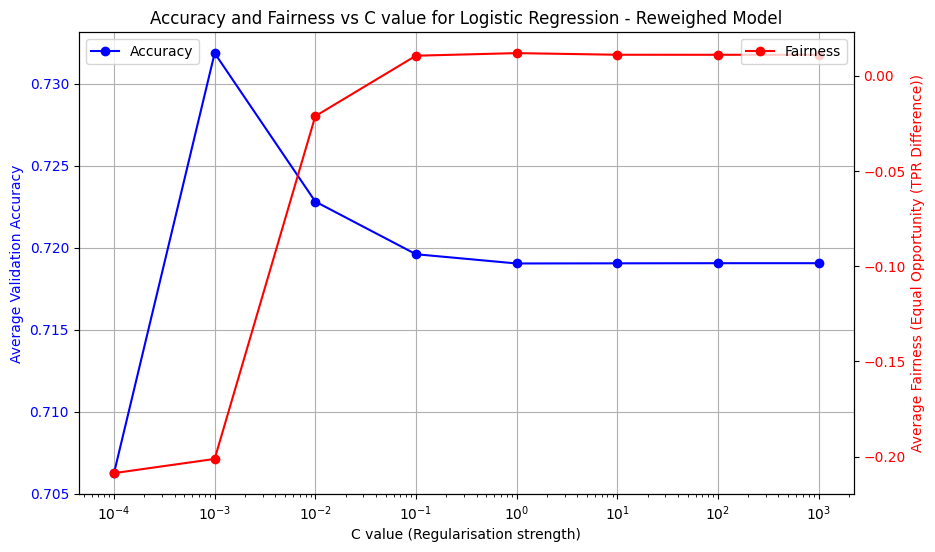

In [22]:
# Range of C values for Logistic Regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# list of values obtained in one of the training episodes
avg_accuracies = [0.7062459975238013,0.7318533065790035,0.7228023737352174,
                   0.7195918541604407,0.7190283055116765,0.719036844127567,
                  0.7190453827434573,0.7190453827434573,]
avg_fairnesses = [-0.20870415893144037,-0.2012610065710933,-0.02127779378942505,
                  0.010445911996897771,0.01180495314444685, 0.010947007981528988,
                 0.01092982880269373,0.01092982880269373 ]

# Create figure and first axis
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plotting accuracy
ax1.plot(C_vals, avg_accuracies, 'b-o', label='Accuracy')
ax1.set_xlabel('C value (Regularisation strength)')
ax1.set_ylabel('Average Validation Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xscale('log')

# Plotting fairness
ax2.plot(C_vals, avg_fairnesses, 'r-o', label='Fairness')
ax2.set_ylabel('Average Fairness (Equal Opportunity (TPR Difference))', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xscale('log')

# Title and grid
plt.title('Accuracy and Fairness vs C value for Logistic Regression - Reweighed Model')
ax1.grid(True)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


##Plotting the results of Tasks 1 and 2 together for easy visualisation

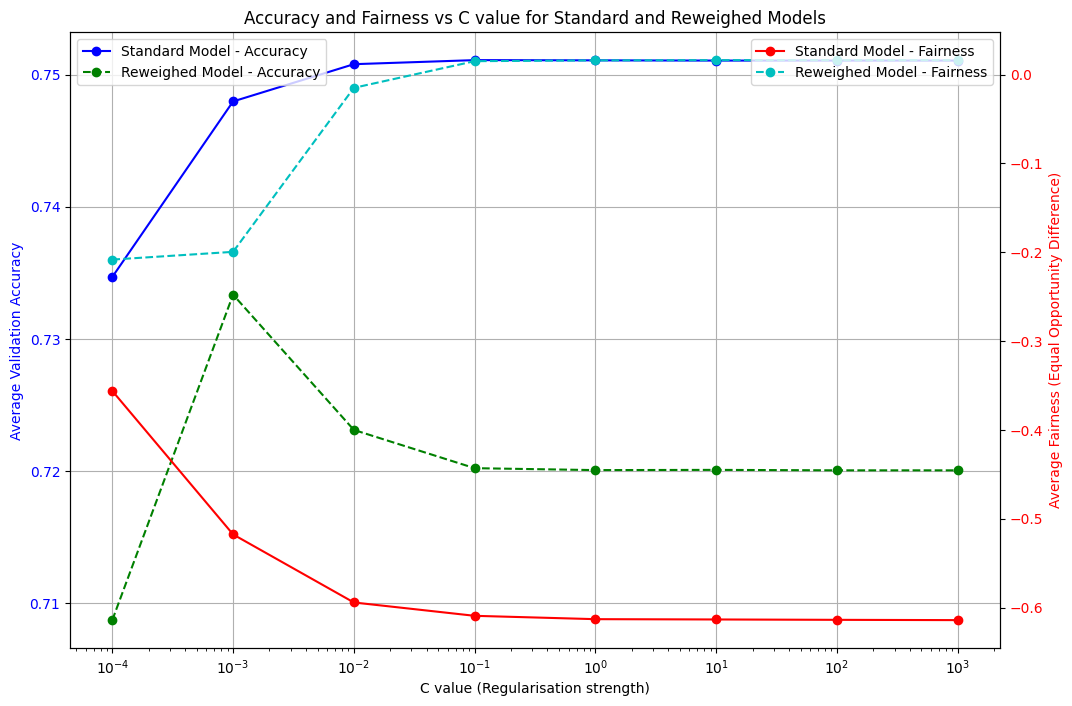

In [21]:
# Range of C values for Logistic Regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# list of values obtained in one of the training episodes
std_avg_accuracies = [0.7346881270546046, 0.7479656747641207, 0.7507834180079409,
                  0.751090808179994, 0.7510737309482133, 0.7510566537164326, 0.7510566537164326, 0.7510566537164326]
std_avg_fairnesses = [-0.3561291042764412, -0.5176610047593677, -0.5942625687301202,
                  -0.6092828780146914, -0.6130552287600122, -0.6133962357153984, -0.6138072088798466, -0.6141323221450352]

# Data for reweighed model
rw_avg_accuracies = list(acc_compare_reweigh.values())
rw_avg_fairnesses = list(fair_compare_reweigh.values())

# Create figure and first axis
plt.figure(figsize=(12, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plotting accuracy for standard model
ax1.plot(C_vals, std_avg_accuracies, 'b-o', label='Standard Model - Accuracy')
# Plotting fairness for standard model
ax2.plot(C_vals, std_avg_fairnesses, 'r-o', label='Standard Model - Fairness')

# Plotting accuracy for reweighed Model
ax1.plot(C_vals, rw_avg_accuracies, 'g--o', label='Reweighed Model - Accuracy')
# Plotting fairness for reweighed Model
ax2.plot(C_vals, rw_avg_fairnesses, 'c--o', label='Reweighed Model - Fairness')

# Labels and settings
ax1.set_xlabel('C value (Regularisation strength)')
ax1.set_ylabel('Average Validation Accuracy', color='b')
ax2.set_ylabel('Average Fairness (Equal Opportunity Difference)', color='r')
ax1.set_xscale('log')
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

# Including features of plot
plt.title('Accuracy and Fairness vs C value for Standard and Reweighed Models')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


##Task 3
##Combined criterion: Using weighted sum of accuracy and fairness metrics as the criterion. This method allows us to assign relative importance to accuracy and fairness based on our specific requirements

##Task 3a: Best standard model

In [57]:
# range of C values for Logistic Regression regularisation
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# weights for the optimisation criterion
w_a = 0.7  # weight for accuracy
w_f = 0.3  # weight for fairness

# initialise variables to track the best model and its performance
best_score = -np.inf
best_C_val = None
best_model = None

# iterate over the range of C values to find the best model
for C_val in C_vals:
    acc_kfold = []  # store k-fold accuracies
    fair_kfold = [] # store k-fold fairness metrics

    # train and validate for each split in cross-validation
    for train_train, train_val in zip(train_train_list, train_val_list):
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train.features, train_train.labels.ravel())
        predictions = lr_model.predict(train_val.features)

        # calculate accuracy for the current fold
        accuracy = accuracy_score(train_val.labels.ravel(), predictions)
        acc_kfold.append(accuracy)

        # calculate fairness metric (Equal Opportunity Difference) for the current fold
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    # calculate the average accuracy and fairness over all folds
    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)

    # Print out the fairness and accuracy at the current C value
    print(f'C={C_val}, Average Validation Accuracy: {avg_acc}, Average Validation Fairness: {avg_fairness}')


    # calculate the optimisation criterion score
    score = w_a * avg_acc - w_f * abs(avg_fairness)

    # update the best model if the current model is better
    if score > best_score:
        best_score = score
        best_C_val = C_val
        best_model = lr_model

# evaluate the best model on the test set
X_test = test.features
y_test = test.labels.ravel()
test_preds = best_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# compute fairness metric (Equal Opportunity Difference) on the test set
test_pred = test.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# report final accuracy, fairness, and the best C value
print(f'best C value for standard model: {best_C_val}')
print(f'final test accuracy of best standard model: {final_acc}')
print(f'final test fairness (Equal Opportunity Difference) of best standard model: {final_fairness_metric}')


C=0.0001, Average Validation Accuracy: 0.6679759211031893, Average Validation Fairness: -0.7681287672290346
C=0.001, Average Validation Accuracy: 0.7385390428211587, Average Validation Fairness: -0.8307282538887863
C=0.01, Average Validation Accuracy: 0.7865602185885667, Average Validation Fairness: -0.659797320314801
C=0.1, Average Validation Accuracy: 0.7908124493019681, Average Validation Fairness: -0.5497961101560288
C=1, Average Validation Accuracy: 0.7903342868121077, Average Validation Fairness: -0.5319139761515335
C=10, Average Validation Accuracy: 0.7901378986466294, Average Validation Fairness: -0.5302062050557214
C=100, Average Validation Accuracy: 0.790103744183068, Average Validation Fairness: -0.5300846393635928
C=1000, Average Validation Accuracy: 0.7901208214148487, Average Validation Fairness: -0.5298083962696702
best C value for standard model: 1000
final test accuracy of best standard model: 0.7894883646796302
final test fairness (Equal Opportunity Difference) of bes

##Task 3b: best fairness-aware model

In [58]:
# list of C values for Logistic Regression regularisation
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# weights for the optimisation criterion
w_a = 0.7  # weight for accuracy
w_f = 0.3  # weight for fairness

best_score = -np.inf
best_C_val = None  # variable to store the best C value
best_model = None

# Reweighing method for fairness-aware training
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Iterate over different C values
for C_val in C_vals:
    acc_kfold = []  # list to store k-fold accuracies
    fair_kfold = [] # list to store k-fold fairness metrics

    # Train and validate for each split in cross-validation
    for train_train, train_val in zip(train_train_list, train_val_list):
        train_train_rw = RW.fit_transform(train_train)  # Apply reweighing to training data
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train_rw.features, train_train_rw.labels.ravel(), sample_weight=train_train_rw.instance_weights)
        predictions = lr_model.predict(train_val.features)

        # Calculate accuracy for the current fold
        accuracy = accuracy_score(train_val.labels.ravel(), predictions)
        acc_kfold.append(accuracy)

        # Calculate fairness metric (Equal Opportunity Difference) for the current fold
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)

    # Print out the fairness and accuracy at the current C value
    print(f'C={C_val}, Average Validation Accuracy: {avg_acc}, Average Validation Fairness: {avg_fairness}')


    # Calculate the optimisation criterion score
    score = w_a * avg_acc - w_f * abs(avg_fairness)

    # Update the best model if the current model is better
    if score > best_score:
        best_score = score
        best_C_val = C_val
        best_model = lr_model

# Evaluate the best model on the test set
X_test = test.features
y_test = test.labels.ravel()
test_preds = best_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Compute fairness metric (Equal Opportunity Difference) on the test set
test_pred = test.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# Report final accuracy, fairness, and the best C value
print(f'best C value for fairness-aware model: {best_C_val}')
print(f'final test accuracy of best fairness-aware model: {final_acc}')
print(f'final test fairness (Equal Opportunity Difference) of best fairness-aware model: {final_fairness_metric}')


C=0.0001, Average Validation Accuracy: 0.6422234555778508, Average Validation Fairness: -0.04139965356473441
C=0.001, Average Validation Accuracy: 0.7177389745122315, Average Validation Fairness: -0.02493002276310141
C=0.01, Average Validation Accuracy: 0.7667591683388123, Average Validation Fairness: -0.059142810547850755
C=0.1, Average Validation Accuracy: 0.7695512957349614, Average Validation Fairness: -0.04671433262421385
C=1, Average Validation Accuracy: 0.7694061392648252, Average Validation Fairness: -0.04445647646277338
C=10, Average Validation Accuracy: 0.7694232164966059, Average Validation Fairness: -0.04303444035258826
C=100, Average Validation Accuracy: 0.7694061392648252, Average Validation Fairness: -0.04306904089189097
C=1000, Average Validation Accuracy: 0.7694061392648252, Average Validation Fairness: -0.04306904089189097
best C value for fairness-aware model: 10
final test accuracy of best fairness-aware model: 0.7686483901817023
final test fairness (Equal Opportuni

## Plotting results of tasks 3a and 3b

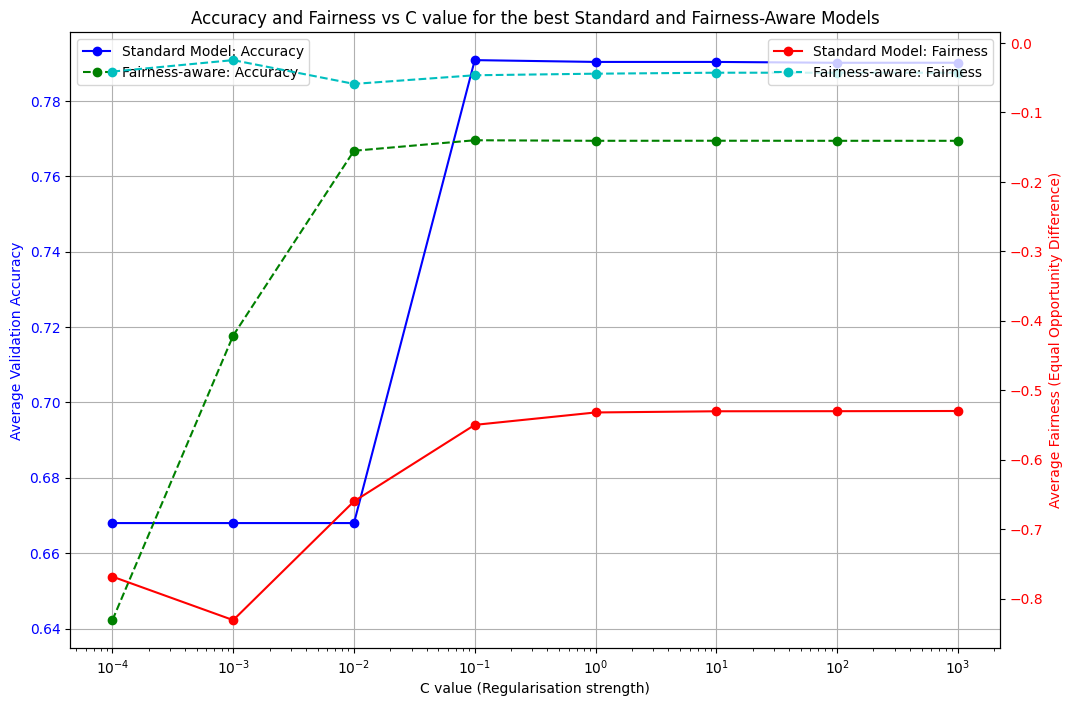

In [61]:
# Range of C values for Logistic Regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# list of values obtained in one of the training episodes
std_avg_accuracies = [0.6679759211031893, 0.6679759211031893, 0.6679759211031893,0.7908124493019681, 0.7903342868121077,
                      0.7903342868121077,0.790103744183068, 0.7901208214148487]
std_avg_fairnesses = [-0.7681287672290346,-0.8307282538887863,-0.659797320314801,-0.5497961101560288,-0.5319139761515335,
                      -0.5302062050557214, -0.5300846393635928,-0.5298083962696702]


# Data for reweighed model
rw_avg_accuracies = [0.6422234555778508, 0.7177389745122315,0.7667591683388123,0.7695512957349614,0.7694061392648252,0.7694232164966059,
                     0.7694061392648252,0.7694061392648252,]
rw_avg_fairnesses = [-0.04139965356473441,-0.02493002276310141,-0.059142810547850755,-0.04671433262421385,-0.04445647646277338,
                     -0.04303444035258826,-0.04306904089189097,-0.04306904089189097]

# Create figure and first axis
plt.figure(figsize=(12, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plotting accuracy for standard model
ax1.plot(C_vals, std_avg_accuracies, 'b-o', label='Standard Model: Accuracy')
# Plotting fairness for standard model
ax2.plot(C_vals, std_avg_fairnesses, 'r-o', label='Standard Model: Fairness')

# Plotting accuracy for best-fairness model
ax1.plot(C_vals, rw_avg_accuracies, 'g--o', label='Fairness-aware: Accuracy')
# Plotting fairness for best-fairness Model
ax2.plot(C_vals, rw_avg_fairnesses, 'c--o', label='Fairness-aware: Fairness')

# Labels and settings
ax1.set_xlabel('C value (Regularisation strength)')
ax1.set_ylabel('Average Validation Accuracy', color='b')
ax2.set_ylabel('Average Fairness (Equal Opportunity Difference)', color='r')
ax1.set_xscale('log')
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

# Including features of plot
plt.title('Accuracy and Fairness vs C value for the best Standard and Fairness-Aware Models')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


## Creating a dot plot to compare the final test accuracies and fairness values of all models

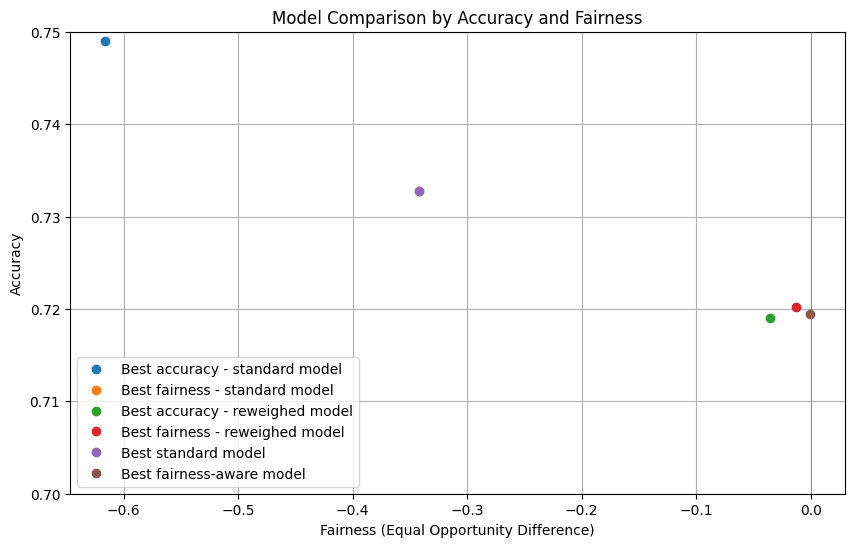

In [24]:
import matplotlib.pyplot as plt

# Data from the table
models = [
    "Best accuracy - standard model",
    "Best fairness - standard model",
    "Best accuracy - reweighed model",
    "Best fairness - reweighed model",
    "Best standard model",
    "Best fairness-aware model"
]

accuracies = [
    0.749024,
    0.732766,
    0.719039,
    0.720155,
    0.732766,
    0.719477
]

fairness = [
    -0.615951,
    -0.341966,
    -0.035527,
    -0.013327,
    -0.341967,
    -0.000946
]

# Create a dot plot
plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    plt.plot(fairness[i], accuracies[i], 'o', label=model)

# Setting the x-axis as 'Fairness' and y-axis as 'Accuracy' and adding plot features
plt.xlabel('Fairness (Equal Opportunity Difference)')
plt.ylabel('Accuracy')
plt.title('Model Comparison by Accuracy and Fairness')
plt.axhline(y=0, color='grey', lw=0.5)
plt.axvline(x=0, color='grey', lw=0.5)
plt.grid(True)
plt.legend()
plt.ylim(0.70, 0.75)

plt.show()


## Testing effects of one-hot encoding

In [36]:
# Convert to pandas DataFrame for easier manipulation
data = pd.DataFrame(features, columns=ACSEmployment.features)
data['label'] = label

# One-hot encode categorical features
categorical_features = [feature for feature in ACSEmployment.features if feature != 'DIS' and feature in data.columns]
data_encoded = pd.get_dummies(data, columns=categorical_features)


# Prepare the StandardDataset with the one-hot encoded data
data_for_aif = StandardDataset(data_encoded, label_name='label', favorable_classes=[True],
                               protected_attribute_names=['DIS'],
                               privileged_classes=[[1]])

# Split dataset into train (0.7) and test (0.3)
dataset_size = data_for_aif.features.shape[0]
train, test = data_for_aif.split([int(dataset_size * 0.7)], shuffle=True)

# Obtain the test dataset
X_test = test.features
y_test = test.labels.ravel()

# Split train into train-train (0.8) and train-val (0.2) for cross-validation
train_train_list = []
train_val_list = []
for i in range(5):
    train_train, train_val = train.split([int(train.features.shape[0] * 0.8)], shuffle=True)
    train_train_list.append(train_train)
    train_val_list.append(train_val)


/usr/local/lib/python3.10/dist-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


In [45]:
# Range of C values for Logistic Regression regularization
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# Weights for the optimization criterion
w_a = 0.7  # Weight for accuracy
w_f = 0.3  # Weight for fairness

# Initialize variables to track the best model and its performance
best_score = -np.inf
best_C_val = None
best_model = None

# Iterate over the range of C values to find the best model
for C_val in C_vals:
    acc_kfold = []  # Store k-fold accuracies
    fair_kfold = []  # Store k-fold fairness metrics

    # Train and validate for each split in cross-validation
    for train_train, train_val in zip(train_train_list, train_val_list):
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train.features, train_train.labels.ravel())
        predictions = lr_model.predict(train_val.features)

        # Calculate accuracy for the current fold
        accuracy = accuracy_score(train_val.labels.ravel(), predictions)
        acc_kfold.append(accuracy)

        # Calculate fairness metric (Equal Opportunity Difference) for the current fold
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    # Calculate the average accuracy and fairness over all folds
    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)

    # Print out the fairness and accuracy at the current C value
    print(f'C={C_val}, Average Validation Accuracy: {avg_acc}, Average Validation Fairness: {avg_fairness}')

    # Calculate the optimisation criterion score
    score = w_a * avg_acc - w_f * abs(avg_fairness)

    # Update the best model if the current model is better
    if score > best_score:
        best_score = score
        best_C_val = C_val
        best_model = lr_model

# Evaluate the best model on the test set
X_test = test.features
y_test = test.labels.ravel()
test_preds = best_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Compute fairness metric (Equal Opportunity Difference) on the test set
test_pred = test.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# Report final accuracy, fairness, and the best C value
print(f'Best C Value for Standard Model: {best_C_val}')
print(f'Final Test Accuracy of Best Standard Model: {final_acc}')
print(f'Final Test Fairness (Equal Opportunity Difference) of Best Standard Model: {final_fairness_metric}')


C=0.0001, Average Validation Accuracy: 0.6695641036587969, Average Validation Fairness: -0.7518606634782864
C=0.001, Average Validation Accuracy: 0.737326559364727, Average Validation Fairness: -0.8181312165565794
C=0.01, Average Validation Accuracy: 0.7861845194893908, Average Validation Fairness: -0.6525844438691178
C=0.1, Average Validation Accuracy: 0.7888314904154037, Average Validation Fairness: -0.5515488044272352
C=1, Average Validation Accuracy: 0.7886948725611578, Average Validation Fairness: -0.5269687121740665
C=10, Average Validation Accuracy: 0.7887887973359519, Average Validation Fairness: -0.5240912809460203
C=100, Average Validation Accuracy: 0.7888058745677325, Average Validation Fairness: -0.5232672003514249
C=1000, Average Validation Accuracy: 0.7887887973359519, Average Validation Fairness: -0.5232498888306079
Best C Value for Standard Model: 100
Final Test Accuracy of Best Standard Model: 0.7899665285304431
Final Test Fairness (Equal Opportunity Difference) of Bes

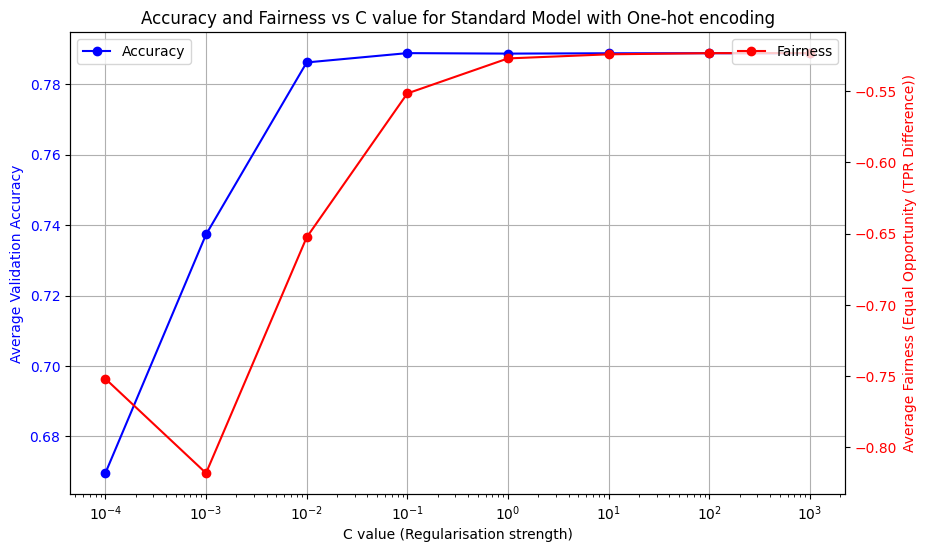

In [51]:
# Range of C values for Logistic Regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# list of values obtained in one of the training episodes
avg_accuracies = [ 0.6695641036587969, 0.737326559364727,0.7861845194893908,0.7888314904154037,0.7886948725611578,
                  0.7887887973359519,0.7888058745677325,0.7887887973359519]
avg_fairnesses = [-0.7518606634782864,-0.8181312165565794,-0.6525844438691178,-0.5515488044272352,-0.5269687121740665,
                  -0.5240912809460203,-0.5232672003514249,-0.5232498888306079]

# Create figure and first axis
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plotting accuracy
ax1.plot(C_vals, avg_accuracies, 'b-o', label='Accuracy')
ax1.set_xlabel('C value (Regularisation strength)')
ax1.set_ylabel('Average Validation Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xscale('log')

# Plotting fairness
ax2.plot(C_vals, avg_fairnesses, 'r-o', label='Fairness')
ax2.set_ylabel('Average Fairness (Equal Opportunity (TPR Difference))', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xscale('log')

# Title and grid
plt.title('Accuracy and Fairness vs C value for Standard Model with One-hot encoding')
ax1.grid(True)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


In [47]:
# list of C values for Logistic Regression regularisation
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# weights for the optimisation criterion
w_a = 0.7  # weight for accuracy
w_f = 0.3  # weight for fairness

best_score = -np.inf
best_C_val = None  # variable to store the best C value
best_model = None

# Reweighing method for fairness-aware training
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Iterate over different C values
for C_val in C_vals:
    acc_kfold = []  # list to store k-fold accuracies
    fair_kfold = [] # list to store k-fold fairness metrics

    # Train and validate for each split in cross-validation
    for train_train, train_val in zip(train_train_list, train_val_list):
        train_train_rw = RW.fit_transform(train_train)  # Apply reweighing to training data
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train_rw.features, train_train_rw.labels.ravel(), sample_weight=train_train_rw.instance_weights)
        predictions = lr_model.predict(train_val.features)

        # Calculate accuracy for the current fold
        accuracy = accuracy_score(train_val.labels.ravel(), predictions)
        acc_kfold.append(accuracy)

        # Calculate fairness metric (Equal Opportunity Difference) for the current fold
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)

    # Print out the fairness and accuracy at the current C value
    print(f'C={C_val}, Average Validation Accuracy: {avg_acc}, Average Validation Fairness: {avg_fairness}')


    # Calculate the optimisation criterion score
    score = w_a * avg_acc - w_f * abs(avg_fairness)

    # Update the best model if the current model is better
    if score > best_score:
        best_score = score
        best_C_val = C_val
        best_model = lr_model

# Evaluate the best model on the test set
X_test = test.features
y_test = test.labels.ravel()
test_preds = best_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Compute fairness metric (Equal Opportunity Difference) on the test set
test_pred = test.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# Report final accuracy, fairness, and the best C value
print(f'best C value for fairness-aware model: {best_C_val}')
print(f'final test accuracy of best fairness-aware model: {final_acc}')
print(f'final test fairness (Equal Opportunity Difference) of best fairness-aware model: {final_fairness_metric}')


C=0.0001, Average Validation Accuracy: 0.6409938948896384, Average Validation Fairness: -0.042064324715592384
C=0.001, Average Validation Accuracy: 0.7172778892541519, Average Validation Fairness: -0.03218732338692698
C=0.01, Average Validation Accuracy: 0.7652905264056696, Average Validation Fairness: -0.060192980981457866
C=0.1, Average Validation Accuracy: 0.7677838022456559, Average Validation Fairness: -0.04439164892144563
C=1, Average Validation Accuracy: 0.7671690219015497, Average Validation Fairness: -0.04078108027517389
C=10, Average Validation Accuracy: 0.7671177902062075, Average Validation Fairness: -0.03973439706633612
C=100, Average Validation Accuracy: 0.7671092515903173, Average Validation Fairness: -0.0397345687539532
C=1000, Average Validation Accuracy: 0.7670921743585365, Average Validation Fairness: -0.0397345687539532
best C value for fairness-aware model: 10
final test accuracy of best fairness-aware model: 0.7685686962065668
final test fairness (Equal Opportunit

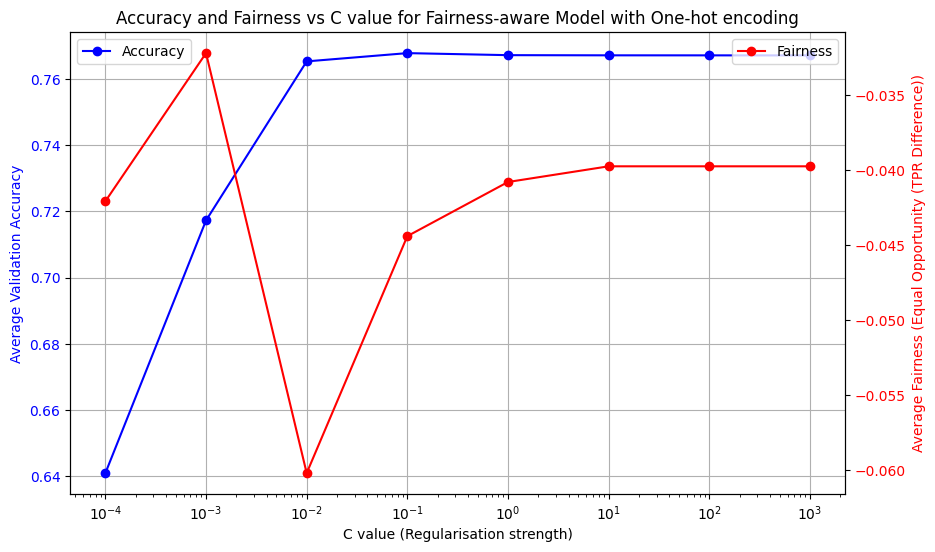

In [52]:
# Range of C values for Logistic Regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

# list of values obtained in one of the training episodes
avg_accuracies = [ 0.6409938948896384,0.7172778892541519,0.7652905264056696,0.7677838022456559,0.7671690219015497, 0.7671177902062075,
                  0.7671092515903173,  0.7670921743585365]
avg_fairnesses = [-0.042064324715592384, -0.03218732338692698, -0.060192980981457866,-0.04439164892144563,-0.04078108027517389,
                 -0.03973439706633612, -0.0397345687539532, -0.0397345687539532]

# Create figure and first axis
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plotting accuracy
ax1.plot(C_vals, avg_accuracies, 'b-o', label='Accuracy')
ax1.set_xlabel('C value (Regularisation strength)')
ax1.set_ylabel('Average Validation Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xscale('log')

# Plotting fairness
ax2.plot(C_vals, avg_fairnesses, 'r-o', label='Fairness')
ax2.set_ylabel('Average Fairness (Equal Opportunity (TPR Difference))', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xscale('log')

# Title and grid
plt.title('Accuracy and Fairness vs C value for Fairness-aware Model with One-hot encoding')
ax1.grid(True)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


## Extension: Perform model selection on data for Florida state (states=[”FL”]), while test on data for Texas (states=[”TX”]). Analyse how this change the performance of the models 1-6

In [ ]:
# Preprocess data for Texas - Test Set
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data_tx = data_source.get_data(states=["TX"], download=True)
features_tx, label_tx, group_tx = ACSEmployment.df_to_numpy(acs_data_tx)

# Create DataFrame and StandardDataset for Texas
data_tx = pd.DataFrame(features_tx, columns=ACSEmployment.features)
data_tx['label'] = label_tx

favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])

test_data_for_aif = StandardDataset(data_tx, 'label', favorable_classes=favorable_classes,
                                    protected_attribute_names=protected_attribute_names,
                                    privileged_classes=privileged_classes)

# Test set for Texas
X_test = test_data_for_aif.features
y_test = test_data_for_aif.labels.ravel()

In [ ]:
# Preprocess data for Florida - Training Set
acs_data_fl = data_source.get_data(states=["FL"], download=True)
features_fl, label_fl, group_fl = ACSEmployment.df_to_numpy(acs_data_fl)

# Create DataFrame and StandardDataset for Florida
data_fl = pd.DataFrame(features_fl, columns=ACSEmployment.features)
data_fl['label'] = label_fl

data_for_aif_fl = StandardDataset(data_fl, 'label', favorable_classes=favorable_classes,
                                  protected_attribute_names=protected_attribute_names,
                                  privileged_classes=privileged_classes)


In [ ]:
# Split Florida dataset into multiple train and validation sets for 5-fold cross-validation
train_train_list = []
train_val_list = []
num_splits = 5

# Perform 5-fold cross-validation
for _ in range(num_splits):
    # Split the data into training and validation sets: 80% and 20%
    train_fl, val_fl = data_for_aif_fl.split([int(data_for_aif_fl.features.shape[0] * 0.8)], shuffle=True)
    train_train_list.append(train_fl)  # Store the training set
    train_val_list.append(val_fl)      # Store the validation set

# Define unprivileged and privileged groups based on the 'DIS' attribute
unprivileged_groups = [{'DIS': 1}]
privileged_groups = [{'DIS': 2}]


##Training and testing on standard model for best accuracy

In [ ]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')

# Load and preprocess the Texas data (test set)
acs_data_tx = data_source.get_data(states=["TX"], download=True)
features_tx, label_tx, group_tx = ACSEmployment.df_to_numpy(acs_data_tx)
data_tx = pd.DataFrame(features_tx, columns=ACSEmployment.features)
data_tx['label'] = label_tx
test_data_for_aif = StandardDataset(data_tx, 'label', favorable_classes=[True],
                                    protected_attribute_names=[ACSEmployment.group],
                                    privileged_classes=[[1]])

# Extract test features and labels
X_test = test_data_for_aif.features
y_test = test_data_for_aif.labels.ravel()

# Load and preprocess the Florida data (training set)
acs_data_fl = data_source.get_data(states=["FL"], download=True)
features_fl, label_fl, group_fl = ACSEmployment.df_to_numpy(acs_data_fl)
data_fl = pd.DataFrame(features_fl, columns=ACSEmployment.features)
data_fl['label'] = label_fl
data_for_aif_fl = StandardDataset(data_fl, 'label', favorable_classes=[True],
                                  protected_attribute_names=[ACSEmployment.group],
                                  privileged_classes=[[1]])

# Split the Florida data into train and validation sets for cross-validation
train_train_list = []
train_val_list = []
num_splits = 5   #5-fold cross-validation
for _ in range(num_splits):
    train_fl, val_fl = data_for_aif_fl.split([int(data_for_aif_fl.features.shape[0] * 0.8)], shuffle=True)
    train_train_list.append(train_fl)
    train_val_list.append(val_fl)

# Define unprivileged and privileged groups
unprivileged_groups = [{'DIS': 1}]
privileged_groups = [{'DIS': 2}]

# initialise variables to store the best model and its performance metrics
best_acc = 0
best_model = None
best_C_val = None

# initialise lists to store metrics for each C value
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
validation_accuracies = []
test_accuracies = []
test_fairnesses = []

# Model selection process
for C_val in C_vals:
    fold_accuracies = []

    # Train and validate the model for each fold
    for train_train, train_val in zip(train_train_list, train_val_list):
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train.features, train_train.labels.ravel())
        val_preds = lr_model.predict(train_val.features)
        fold_accuracies.append(accuracy_score(train_val.labels.ravel(), val_preds))

    # Calculate the average accuracy for the current C value
    avg_acc = np.mean(fold_accuracies)
    validation_accuracies.append(avg_acc)
    print(f'C={C_val}, Average Validation Accuracy: {avg_acc}')

    # Update the best model if the current model is better
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_model = lr_model
        best_C_val = C_val

# Test the best model on the Texas test set
test_preds = best_model.predict(X_test)
final_test_acc = accuracy_score(y_test, test_preds)
test_accuracies.append(final_test_acc)

# Compute and store fairness for the best model
test_pred = test_data_for_aif.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test_data_for_aif, test_pred,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)
final_test_fairness = metric_test.equal_opportunity_difference()
test_fairnesses.append(final_test_fairness)

# Reporting final accuracy and fairness of the best model
print(f'Best C Value: {best_C_val}')
print(f'Final Test Accuracy: {final_test_acc}')
print(f'Final Test Fair:{final_test_fairness}')


C=0.0001, Average Validation Accuracy: 0.7392684238838086
C=0.001, Average Validation Accuracy: 0.7490227720996951
C=0.01, Average Validation Accuracy: 0.7506604506604506
C=0.1, Average Validation Accuracy: 0.7507022891638278
C=1, Average Validation Accuracy: 0.7506963122347738
C=10, Average Validation Accuracy: 0.7507261968800429
C=100, Average Validation Accuracy: 0.7507620584543662
C=1000, Average Validation Accuracy: 0.7507441276672046
Best C Value: 100
Final Test Accuracy: 0.7309534551109149
Final Test Fair:-0.6122071857231837


##Training and testing on standard model for best fairness-metric

In [ ]:
# Range of C values for Logistic Regression
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
best_acc = 0
best_model = None

for C_val in C_vals:
    accuracies = []

    for train_train, train_val in zip(train_train_list, train_val_list):
        # Train model
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train.features, train_train.labels.ravel())

        # Evaluate on validation set
        val_preds = lr_model.predict(train_val.features)
        accuracy = accuracy_score(train_val.labels.ravel(), val_preds)
        accuracies.append(accuracy)

    # Average accuracy for this C value
    avg_acc = np.mean(accuracies)
    print(f'C={C_val}, Average Validation Accuracy: {avg_acc}')

    # Update best model if current model is better
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_model = lr_model


# Evaluating the best model on the Texas test set
test_preds = best_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Computing fairness
test_pred = test_data_for_aif.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test_data_for_aif, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff = metric_test.equal_opportunity_difference()  # Fairness metric

# Reporting final accuracy and fairness
print(f'Final Test Accuracy: {final_acc}')
print(f'Final Test Fairness (Equal Opportunity Difference): {eq_opp_diff}')


C=0.0001, Average Validation Accuracy: 0.7392684238838086
C=0.001, Average Validation Accuracy: 0.7490227720996951
C=0.01, Average Validation Accuracy: 0.7506604506604506
C=0.1, Average Validation Accuracy: 0.7507022891638278
C=1, Average Validation Accuracy: 0.7506963122347738
C=10, Average Validation Accuracy: 0.7507261968800429
C=100, Average Validation Accuracy: 0.7507620584543662
C=1000, Average Validation Accuracy: 0.7507441276672046
Final Test Accuracy: 0.7309534551109149
Final Test Fairness (Equal Opportunity Difference): -0.6122071857231837


##Training and testing on best accuracy-reweighed model

In [ ]:
# Define regularisation strengths for model comparison
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
best_acc = 0  # Best accuracy placeholder
best_model = None  # Best model placeholder

# Initialise reweighing for fairness adjustment
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Iterate over different values of C to find the best model
for C_val in C_vals:
    acc_kfold = []  # List to store k-fold accuracies
    fair_kfold = []  # List to store k-fold fairness

    # Cross-validation over train-train/train-val splits
    for train_train, train_val in zip(train_train_list, train_val_list):
        # Apply reweighing to adjust weights for fairness
        train_train_rw = RW.fit_transform(train_train)
        X_train = train_train_rw.features
        y_train = train_train_rw.labels.ravel()
        X_val = train_val.features
        y_val = train_val.labels.ravel()

        # Train logistic regression model with L1 regularisation
        learner = LogisticRegression(C=C_val, solver='liblinear', penalty='l1', random_state=1)
        learner.fit(X_train, y_train, sample_weight=train_train_rw.instance_weights)
        predictions = learner.predict(X_val)

        # Evaluate accuracy on the validation set
        accuracy = accuracy_score(y_val, predictions)
        acc_kfold.append(accuracy)

        # Evaluate fairness using equal opportunity difference
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    # Calculate average accuracy and fairness from k-folds
    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)

    # Update the best model based on highest average accuracy
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_model = learner

# Test the best model on the Texas dataset
test_preds = best_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Assess fairness of the model on the Texas dataset
test_pred = test_data_for_aif.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test_data_for_aif, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# Output final accuracy and fairness results
print(f'Final Test Accuracy: {final_acc}')
print(f'Final Test Fairness (Equal Opportunity Difference): {final_fairness_metric}')


Final Test Accuracy: 0.7079641770414383
Final Test Fairness (Equal Opportunity Difference): -0.1799125724471763


##Training and testing on fairness reweighed model

In [ ]:
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
acc_compare_reweigh = {}  # Stores accuracies for comparison
fair_compare_reweigh = {}  # Stores fairness scores for comparison
best_fairness = float('inf')  # Initialise best fairness score
best_fairness_C_val = None  # C value for best fairness model
best_fairness_model = None  # Best model for fairness
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)  # Reweighing instance

# Iterate through C values to find the model with the best fairness
for C_val in C_vals:
    acc_kfold = []  # List of accuracies per fold
    fair_kfold = []  # List of fairness per fold

    # Cross-validation
    for train_train, train_val in zip(train_train_list, train_val_list):
        # Apply reweighing to the training data
        train_train = RW.fit_transform(train_train)
        X_train = train_train.features
        y_train = train_train.labels.ravel()
        X_val = train_val.features
        y_val = train_val.labels.ravel()

        # Train logistic regression with L1 penalty
        learner = LogisticRegression(C=C_val, solver='liblinear', penalty='l1', random_state=1)
        learner.fit(X_train, y_train, sample_weight=train_train.instance_weights)
        predictions = learner.predict(X_val)

        # Compute accuracy for the validation set
        accuracy = sum(predictions == y_val) / len(y_val)
        acc_kfold.append(accuracy)

        # Compute fairness using Equal Opportunity Difference
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    # Calculate average accuracy and fairness across folds
    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)
    acc_compare_reweigh[C_val] = avg_acc
    fair_compare_reweigh[C_val] = avg_fairness

    # Update best fairness score and corresponding model
    if abs(avg_fairness) < abs(best_fairness):
        best_fairness = avg_fairness
        best_fairness_C_val = C_val
        best_fairness_model = learner

# Prepare test data
X_test = test.features
y_test = test.labels.ravel()

# Evaluate best model for fairness on the test set
test_preds = best_fairness_model.predict(X_test)
final_acc = accuracy_score(y_test, test_preds)

# Assess fairness on test data
test_pred = test.copy()
test_pred.labels = test_preds
metric_test = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric = metric_test.equal_opportunity_difference()

# Output best C value for fairness and model's performance
print(f'Best C value for Fairness: {best_fairness_C_val}')
print(f'Final Test Accuracy of Best Fairness Model: {final_acc}')
print(f'Final Test Fairness (Equal Opportunity Difference) of Best Fairness Model: {final_fairness_metric}')


Best C value for Fairness: 0.01
Final Test Accuracy of Best Fairness Model: 0.7230235894166401
Final Test Fairness (Equal Opportunity Difference) of Best Fairness Model: 0.0046419770511004765


##Testing on the combined models

In [ ]:
# Training the Standard Model on Florida Data
best_score_standard = -np.inf
best_C_val_standard = None
best_model_standard = None

# Loop over various values of C to find the optimal standard logistic regression model
for C_val in C_vals:
    acc_kfold = []
    fair_kfold = []

    # Perform cross-validation
    for train_train, train_val in zip(train_train_list, train_val_list):
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train.features, train_train.labels.ravel())
        predictions = lr_model.predict(train_val.features)

        # calculate accuracy and fairness
        accuracy = accuracy_score(train_val.labels.ravel(), predictions)
        acc_kfold.append(accuracy)
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

  # determine the average accuracy and fairness, and calculate the composite score
    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)
    score = w_a * avg_acc - w_f * abs(avg_fairness)

    # Update the best model if the current score is higher
    if score > best_score_standard:
        best_score_standard = score
        best_C_val_standard = C_val
        best_model_standard = lr_model

# Training the Fairness-Aware Model on Florida Data
best_score_fairness = -np.inf
best_C_val_fairness = None
best_model_fairness = None
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Loop over various values of C to find the optimal standard logistic regression model
for C_val in C_vals:
    acc_kfold = []
    fair_kfold = []

    # Perform cross-validation
    for train_train, train_val in zip(train_train_list, train_val_list):
        train_train_rw = RW.fit_transform(train_train)
        lr_model = LogisticRegression(C=C_val, solver='liblinear')
        lr_model.fit(train_train_rw.features, train_train_rw.labels.ravel(), sample_weight=train_train_rw.instance_weights)
        predictions = lr_model.predict(train_val.features)

        # calculate accuracy and fairness
        accuracy = accuracy_score(train_val.labels.ravel(), predictions)
        acc_kfold.append(accuracy)
        val_pred = train_val.copy()
        val_pred.labels = predictions
        clf_metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        eq_opp_diff = clf_metric.equal_opportunity_difference()
        fair_kfold.append(eq_opp_diff)

    # determine the average accuracy and fairness, and calculate the composite score
    avg_acc = np.mean(acc_kfold)
    avg_fairness = np.mean(fair_kfold)
    score = w_a * avg_acc - w_f * abs(avg_fairness)

    # Update the best model if the current score is higher
    if score > best_score_fairness:
        best_score_fairness = score
        best_C_val_fairness = C_val
        best_model_fairness = lr_model


# Evaluating the Models on Texas Data
test_preds_texas_standard = best_model_standard.predict(X_test)
final_acc_texas_standard = accuracy_score(y_test, test_preds_texas_standard)
test_pred_texas_standard = test_data_for_aif.copy()
test_pred_texas_standard.labels = test_preds_texas_standard
metric_test_texas_standard = ClassificationMetric(test_data_for_aif, test_pred_texas_standard, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric_texas_standard = metric_test_texas_standard.equal_opportunity_difference()

test_preds_texas_fairness = best_model_fairness.predict(X_test)
final_acc_texas_fairness = accuracy_score(y_test, test_preds_texas_fairness)
test_pred_texas_fairness = test_data_for_aif.copy()
test_pred_texas_fairness.labels = test_preds_texas_fairness
metric_test_texas_fairness = ClassificationMetric(test_data_for_aif, test_pred_texas_fairness, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
final_fairness_metric_texas_fairness = metric_test_texas_fairness.equal_opportunity_difference()

# printing metrics
print(f"Standard Model - Texas Test Accuracy: {final_acc_texas_standard}, Fairness: {final_fairness_metric_texas_standard}")
print(f"Fairness-Aware Model - Texas Test Accuracy: {final_acc_texas_fairness}, Fairness: {final_fairness_metric_texas_fairness}")


Standard Model - Texas Test Accuracy: 0.716598354754797, Fairness: -0.36638906800789883
Fairness-Aware Model - Texas Test Accuracy: 0.7009810038491443, Fairness: -0.01871527658936556


## Creating a dot plot to compare the final test accuracies and fairness values of all models after model selection on FL data and testing on TX data

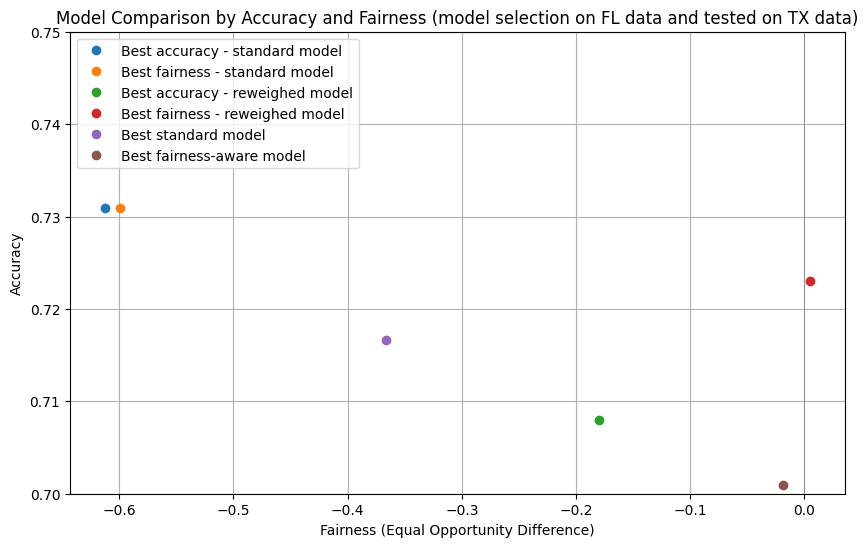

In [27]:
import matplotlib.pyplot as plt

# Data from the table
models = [
    "Best accuracy - standard model",
    "Best fairness - standard model",
    "Best accuracy - reweighed model",
    "Best fairness - reweighed model",
    "Best standard model",
    "Best fairness-aware model"
]

accuracies = [
    0.730953,
    0.730953,
    0.707964,
    0.723024,
    0.716598,
    0.700981
]

fairness = [
    -0.612207,
    -0.599702,
    -0.179913,
    0.004642,
    -0.366389,
    -0.018715
]

# Create a dot plot
plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    plt.plot(fairness[i], accuracies[i], 'o', label=model)

# Setting the x-axis as 'Fairness' and y-axis as 'Accuracy'
plt.xlabel('Fairness (Equal Opportunity Difference)')
plt.ylabel('Accuracy')
plt.title('Model Comparison by Accuracy and Fairness (model selection on FL data and tested on TX data)')
plt.axhline(y=0, color='grey', lw=0.5)
plt.axvline(x=0, color='grey', lw=0.5)
plt.grid(True)
plt.legend()

# Adjusting the y-axis to start from 0.70 and end at 0.75
plt.ylim(0.70, 0.75)

plt.show()
